In [1]:
import pandas as pd
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

In [2]:
training_data = pd.read_csv("../Data/train_lyrics_1000.csv",header=0,encoding='utf-8')
testing_data = pd.read_csv("../Data/valid_lyrics_200.csv",header=0,encoding='utf-8')

In [3]:
training_data.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [4]:
# Splitting the Dataset into training and test data

X_train = training_data['lyrics']
y_train = testing_data['lyrics']
X_test = training_data['mood']
y_test = testing_data['mood']

In [5]:
# Label Encoding the Target Variable
from sklearn import preprocessing

# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

# Fit the encoder to the pandas column
le.fit(X_test)
le.fit(y_test)

# View the labels (if you want)
list(le.classes_)

# Apply the fitted encoder to the pandas column
X_test = le.transform(X_test) 
y_test = le.transform(y_test)

In [6]:
# Porter Stemmer

import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

In [7]:
with open('../Data/stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


# #Vectorizing Using TF-IDF Vectorizer

In [8]:
# Vectorizing Using TFIDF Vectorizer

NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
#MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'stop_words':stop_words,
            'tokenizer':porter_tokenizer,
            'binary':False,
            'encoding':'utf-8',
        }

In [9]:
# Vectorizing Using TFIDF Vectorizer

NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
#MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'stop_words':stop_words,
            'tokenizer':porter_tokenizer,
            'binary':False,
            'encoding':'utf-8',
        }

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(**kwargs)

In [11]:
# Learn vocabulary from training texts and vectorize training texts.
x_train_tfidf = vectorizer.fit_transform(X_train)

# Vectorize validation texts.
x_val_tfidf = vectorizer.transform(y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
#Defining Parameters for the Model

learning_rate=1e-3
epochs=1000
batch_size=128
layers=2
units=64
dropout_rate=0.2

In [13]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

In [14]:
get_num_classes(X_test)

2

In [15]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.
    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [16]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.
    # Arguments
        num_classes: int, number of classes.
    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [17]:
_get_last_layer_units_and_activation(2)

(1, 'sigmoid')

In [18]:
op_units, op_activation = _get_last_layer_units_and_activation(2)

In [19]:
# Create model instance.
model = mlp_model(layers=layers,
                  units=units,
                  dropout_rate=dropout_rate,
                  input_shape=x_train_tfidf.shape[1:],
                  num_classes=2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# Compile model with learning parameters.

import tensorflow as tf

loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [21]:
#Create callback for early stopping on validation loss. If the loss does not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2)]

In [22]:
# Train and validate model.
history = model.fit(
            x_train_tfidf,
            X_test,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val_tfidf, y_test),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

Train on 1000 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 3s - loss: 0.6909 - acc: 0.5560 - val_loss: 0.6905 - val_acc: 0.4850
Epoch 2/1000
 - 3s - loss: 0.6583 - acc: 0.6560 - val_loss: 0.6867 - val_acc: 0.4900
Epoch 3/1000
 - 3s - loss: 0.6113 - acc: 0.8620 - val_loss: 0.6779 - val_acc: 0.5150
Epoch 4/1000
 - 3s - loss: 0.5516 - acc: 0.9820 - val_loss: 0.6672 - val_acc: 0.5500
Epoch 5/1000
 - 3s - loss: 0.4842 - acc: 0.9960 - val_loss: 0.6552 - val_acc: 0.5700
Epoch 6/1000
 - 3s - loss: 0.4154 - acc: 0.9970 - val_loss: 0.6451 - val_acc: 0.6050
Epoch 7/1000
 - 3s - loss: 0.3509 - acc: 0.9970 - val_loss: 0.6345 - val_acc: 0.6250
Epoch 8/1000
 - 3s - loss: 0.2938 - acc: 0.9970 - val_loss: 0.6236 - val_acc: 0.6600
Epoch 9/1000
 - 3s - loss: 0.2489 - acc: 0.9960 - val_loss: 0.6153 - val_acc: 0.6650
Epoch 10/1000
 - 3s - loss: 0.2081 - acc: 0.9960 - val_loss: 0.6068 - val_acc: 0.6850
Epoch 11/1000
 - 3s - loss: 0.1746 - acc: 0.9970 - val

In [23]:
# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
        acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Validation accuracy: 0.7049999833106995, loss: 0.5759593677520752


# test

In [24]:
x = 'Without you, I feel broke Like Im half of a whole Without you, Ive got no hand to hold Without you, I feel torn Like a sail in a storm Without you, Im just a sad song Im just a sad song'

In [25]:
x_input = vectorizer.transform([x])

In [26]:
#x_input = selector.transform(x_input).astype('float32')


predictions = model.predict(x_input)

In [27]:
import numpy as np
rounded = [np.round(x) for x in predictions]

In [28]:
if rounded[0] == 1:
    print('happy')
else:
    print('sad')

happy


In [37]:
# Plotting the confusion Matrix Using Logistic Regression on Word Level TF-IDF

import matplotlib as mpl
import numpy as np

def plot_cm(X, y, clf, title):

    predictions = clf.predict(X)
    rounded = [np.round(x) for x in predictions]
    cm = metrics.confusion_matrix(y, rounded)

    np.set_printoptions(suppress=True)
    mpl.rc("figure", figsize=(4, 2))

    hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
    plt.title(title)
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.tight_layout()
    plt.show()

# plotting confusion matrix

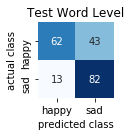

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics 

plot_cm(x_val_tfidf, y_test, model, 'Test Word Level')

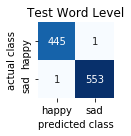

In [40]:
plot_cm(x_train_tfidf, X_test, model, 'Test Word Level')

# Calculating F-1 Score

### Training Level

In [41]:
#precision = (TP)/(TP+FP) 
#recall = (TP)/(P)
#accuracy = (TP+TN)/(P+N)
#f-measure = 2 * (precision x recall)/(precision + recall)

In [42]:
precision_train = 445/(445+1)
recall_train = 445/445+1
accuracy_train = (445+553)/(1000)
f_score_train = 2 * ((precision_train * recall_train)/(precision_train+recall_train))

In [43]:
print("Precision of the Training Set is: ",round(precision_train*100,2),"%")
print("Recall of the Training Set is: ",round(recall_train*100,2),"%")
print("Accuracy of the Training Set is: ",round(accuracy_train*100,2),"%")
print("F1 Score of the Training Set is: ",round(f_score_train*100,2),"%")

Precision of the Training Set is:  99.78 %
Recall of the Training Set is:  200.0 %
Accuracy of the Training Set is:  99.8 %
F1 Score of the Training Set is:  133.13 %


### Testing Level

In [44]:
precision_test = 62/(62+43)
recall_test = 62/(62+13)
accuracy_test = (62+82)/(200)
f_score_test = 2 * ((precision_test * recall_test)/(precision_test + recall_test))

print("Precision of the Testing Set is: ",round(precision_test*100,2),"%")
print("Recall of the Testing Set is: ",round(recall_test*100,2),"%")
print("Accuracy of the Testing Set is: ",round(accuracy_test*100,2),"%")
print("F1 Score of the Testing Set is: ",round(f_score_test*100,2),"%")

Precision of the Testing Set is:  59.05 %
Recall of the Testing Set is:  82.67 %
Accuracy of the Testing Set is:  72.0 %
F1 Score of the Testing Set is:  68.89 %


# Plotting ROC Curve

In [47]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(x_val_tfidf)
preds = probs[:]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

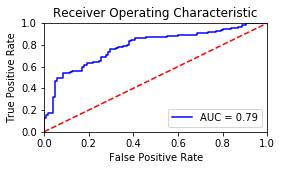

In [48]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()